In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score
from itertools import product
from sklearn.preprocessing import label_binarize

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2482)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    #'subject_len': mail_dict['subject_len'],
                    #'body_len': mail_dict['body_len'],
                    #'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    #'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    #'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    #'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    #'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    #'return_path_match_from': mail_dict['return_path_match_from'],
                    #'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    #'Content-type': mail_dict['Content-type'],
                    #'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    #'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    #'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    #'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    #'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    #'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    #'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    #'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    #'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    #'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    #'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    #'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    #'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    #'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    #'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    #'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    #'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    #'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    #'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    #'has_defects': mail_dict['has_defects'],
                    #'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    #'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Have a wonderful Christmas and a joyous New Year!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- CUST. OBD-66-41275 Rodney Cole.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pat due invoice notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Completed- Please DocuSign these documents.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice number 22028027-LFYJ#WDBB-2017 (27 Nov 17) Notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Inbound- 5 new.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Past due invoice .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice # 530522431 Problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 2U5

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [EXT] Payment status.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment to .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice- 0955202-QXI#KPI-2017 (28 Nov 17).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- IMPORTANT - William Olberding  Invitation to view..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scanned document received from Dropbox User.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Rechnung IIS - 637-LMK2956  .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice[2].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- thy.nguyen@pinnacol.com Be careful! malicious software ID a5iQmYe1e.eml
/Users/worshamn/Documents/emai

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Autumn Hernandez.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Unable to process disbursement due to missing bank account information.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[4].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Contract Agreement-Investment Forecast.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Information.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- PayPal Reminder.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Tracking Number 5OX66928867835423.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE STATUS[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Explicit Content- For men over 30 ONLY!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish A

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Overdue payment.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Possible Spam - [EXT] Payment status.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice # 7338953249 Problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- C Fisher.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your Legally Binding Contract document is ready for signature!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Invoice #00990339554.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Cheryl Dyer.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Incoming wireless message from +17323205192.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Col

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- See what’s new in Loggly 3.0.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You need video evidence.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Does Your Workplace Wellness Work An Interview with Laura Putnam.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Regulation Panel in Cape Town.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Paul.finamore your home could have doubled in vale this year.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Kohl's wants to give you $50.00 for your feedback..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Complimentary Gun Holder (Ends Tonight!).eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Elway's Steak Lunch Event Nov 14th- Eliminating Hybrid Cloud complexity with Dell EMC Azure Stack .eml
/Users/worshamn/Documents/email

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- REMINDER- $35 Survey – Claims Adjuster Survey.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- How to Keep Online Assets Secure.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- PMP Training.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Presentación sin título - Invitation to edit.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- no-cost benefits.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Golf Tech Cures Golf Swing Flaws Quickly.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Daily Rates - 02.15.18.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Sharepoint and Office 365 follow-up.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Michael - client reviews and your profile.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Daily on Healthcare- HHS's Azar says he will enforce Obamacare if Idaho violates law.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Step Denver Gives Back to the Ballpark Community! Read More in the November Newsletter.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 6 killer applications for AI in contact center customer service for 2017 (including real-world examples).eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- $10 Survey - HR Professional Survey.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Geopointe- #1 Rated Mapping Tool on Salesforce.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Erinnerung wegen eBook-Verdienst.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Shark Tank judges can't contain themselves.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\]'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Best marketing solution for Pinnacol Assurance.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] hiring Colorado talent.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Save $1,100 thru Friday  Get In-Depth Knowledge.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Email Account Hacked.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You need to lower your blood pressure.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Demo for new Digital Customer Onboarding.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- MICHAEL! You are PRE-APPROVED!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Confront Industry Transitions  Save $1,000.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Email.eml
/Users/worshamn/Documents/emailProject/IgnoreF

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Card ready! Unlock your pre-loaded card today by midnight.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Credentials 101- What You Need to Know to Keep Your Business Safe.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- mPower March Insights- Predictive Analytics in Workers' Comp and Visualizing Claims Data.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- → 8 Jobs for Medical Payments Services Manager - Denver.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Includes- Apple's Great Marketing Trick Roman Numerals.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Sign Up Today! Health Headliners pres. Eric Neufeld on Prosthetics.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Letters of Credit for Importers - Exporters.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Prime Santa Fe Value-Add Anchored Retail Asset With Substantial Upside.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Virtual event] See a demo of chatbots in action.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Health Insurances .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Evaluating Our Solutions Join Us and Save 50%.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Interested in becoming a Certified Ethical Hacker.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don't have a Will Use your service!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You don't know the value of your home.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- We Wheelie Like You!.eml


Convert cells that are not recognized as a number or just to get rid of float

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 2 columns):
target    784 non-null object
text      784 non-null object
dtypes: object(2)
memory usage: 12.3+ KB


Create a function to clean the text

In [11]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
    #         stopwords_nltk = sorted(nltk.corpus.stopwords.words('english'))
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text

In [12]:
from time import time
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 9.015s


In [13]:
df['cleaned_text'] = pd.Series(corpus).values

In [14]:
df.sample(10,random_state=123)

,target,text,cleaned_text
384,ignore,Get the most out of your studies Hey Sabrina.w...,study hey sabrinawillishaywood mention have tr...
164,investigate,Payment to Transaction # 68M6WZF3N84J45K ...,payment transaction mwzfnjk hi amanda...
729,ignore,You could have a $55k salary who lived in engl...,k salary live england serve wwii come boston b...
689,ignore,A Special Message From MTI CAN’T SEE IMAGE? CL...,special message mti not image click img ...
200,investigate,100.net; s 161025; h=x-gm-message-state:date...,net s hxgmmessagestatedatefromtomessageid...
776,ignore,Prime Santa Fe Value-Add Anchored Retail Asset...,prime santa fe valueadd anchor retail asset su...
476,ignore,Share Your Feedback â Win an Instant Pot We’...,share feedback â win instant pot be give awa...
378,investigate,ShareFile Message From: Scott Houge ShareFile ...,sharefile message scott houge sharefile encryp...
565,ignore,Big announcements from our September event. ...,big announcement september event monumen...
392,ignore,Two sisters want you to try what they discover...,sister want try discover michellebarne be sorr...


Split the sample set into test and training sets

In [15]:
df_target = df['target']
df_feats = df['cleaned_text']
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350,
    stratify=df_target
)

#### TFIDF Creation

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=True
)
train_feats = vectorizer.fit_transform(train_feats.values.tolist())
test_feats = vectorizer.transform(test_feats.values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.448s


In [17]:
train_feats.shape

(627, 8983)

In [18]:
test_feats.shape

(157, 8983)

In [19]:
train_labels.value_counts()

ignore         320
investigate    307
Name: target, dtype: int64

In [20]:
test_labels.value_counts()

ignore         80
investigate    77
Name: target, dtype: int64

#### LSA

In [21]:
svd = TruncatedSVD(n_components=155)
train_feats = svd.fit_transform(train_feats)
train_feats.shape

(627, 155)

In [22]:
test_feats = svd.transform(test_feats)
test_feats.shape

(157, 155)

In [23]:
type(train_feats)

numpy.ndarray

In [24]:
train_feats.view()

array([[ 0.13452179,  0.67118094, -0.15278551, ..., -0.03959558,
         0.04003813,  0.0104573 ],
       [ 0.07434895, -0.0230729 , -0.04463017, ..., -0.05180538,
        -0.07986711,  0.0586489 ],
       [ 0.13973307, -0.03947676, -0.06147734, ..., -0.01755686,
         0.02658943, -0.00195793],
       ...,
       [ 0.18371272, -0.04804726, -0.07566393, ..., -0.04575778,
         0.04389511,  0.13442205],
       [ 0.06179194,  0.01619549, -0.0137715 , ..., -0.0210797 ,
        -0.02370219, -0.00357545],
       [ 0.12490743,  0.01236617,  0.05278694, ..., -0.05137764,
        -0.0339504 , -0.03966428]])

Function to keep track of scoring and for printing results out

In [25]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'recall' not in score_dict:
        score_dict['recall'] = []    
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    recall = recall_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['recall'].append((clf_name,recall))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('Recall score: %0f' % recall)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [26]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.014s
LinearSVC Scores:

Accuracy of data already seen: 0.9713
Accuracy of data not seen: 0.9299
F1 score: 0.9272
Recall score: 0.909091
False Negatives: 7


In [27]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 0.084s
SVC Scores:

Accuracy of data already seen: 0.5104
Accuracy of data not seen: 0.5096
F1 score: 0.0000
Recall score: 0.000000
False Negatives: 77


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Extra Trees Classifier

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 0.165s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9299
F1 score: 0.9281
Recall score: 0.922078
False Negatives: 6


Get Feature Importances

In [29]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. 2 (0.128158)
2. 1 (0.063218)
3. 3 (0.054460)
4. 4 (0.023712)
5. 0 (0.017172)
6. 9 (0.015213)
7. 12 (0.012564)
8. 14 (0.011086)
9. 27 (0.010609)
10. 15 (0.009311)
11. 41 (0.008712)
12. 19 (0.008644)
13. 21 (0.008001)
14. 16 (0.007964)
15. 154 (0.007611)
16. 13 (0.007394)
17. 11 (0.006797)
18. 96 (0.006792)
19. 6 (0.006776)
20. 53 (0.006757)
21. 33 (0.006731)
22. 24 (0.006499)
23. 7 (0.006343)
24. 18 (0.006219)
25. 43 (0.006219)


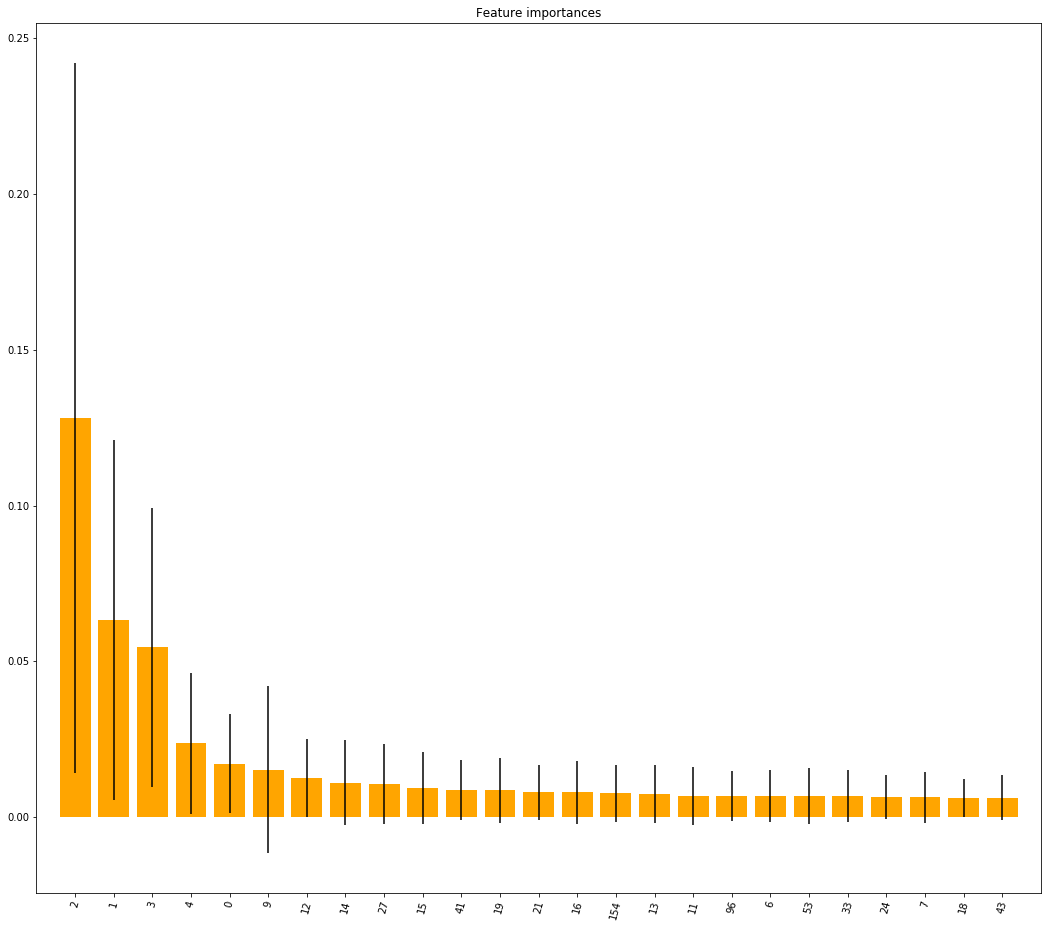

In [30]:
top_indices = indices[:25]
top_features = [i for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 0.661s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9299
F1 score: 0.9281
Recall score: 0.922078
False Negatives: 6


#### XGBoost

In [32]:
from xgboost import XGBClassifier
t0 = time()
xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
xgb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,xgb_clf)

done in 0.677s
XGBClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9299
F1 score: 0.9281
Recall score: 0.922078
False Negatives: 6


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Neural Net

In [33]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 1.045s
MLPClassifier Scores:

Accuracy of data already seen: 0.9968
Accuracy of data not seen: 0.9172
F1 score: 0.9116
Recall score: 0.870130
False Negatives: 10


#### Naive Bayes

In [34]:
# from sklearn.naive_bayes import MultinomialNB
# t0 = time()
# nb_clf = MultinomialNB(alpha=.001)
# nb_clf.fit(train_feats, train_labels)
# #nb_pred = nb_clf.predict(test_feats.drop('TAP-Score',axis=1))
# print("done in %0.3fs" % (time() - t0))
# score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

In [35]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.004s
GaussianNB Scores:

Accuracy of data already seen: 0.8931
Accuracy of data not seen: 0.8662
F1 score: 0.8489
Recall score: 0.766234
False Negatives: 18


#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.274s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9172
F1 score: 0.9161
Recall score: 0.922078
False Negatives: 6


In [37]:
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# features = vectorizer.get_feature_names()
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. 2 (0.128158)
2. 1 (0.063218)
3. 3 (0.054460)
4. 4 (0.023712)
5. 0 (0.017172)
6. 9 (0.015213)
7. 12 (0.012564)
8. 14 (0.011086)
9. 27 (0.010609)
10. 15 (0.009311)
11. 41 (0.008712)
12. 19 (0.008644)
13. 21 (0.008001)
14. 16 (0.007964)
15. 154 (0.007611)
16. 13 (0.007394)
17. 11 (0.006797)
18. 96 (0.006792)
19. 6 (0.006776)
20. 53 (0.006757)
21. 33 (0.006731)
22. 24 (0.006499)
23. 7 (0.006343)
24. 18 (0.006219)
25. 43 (0.006219)


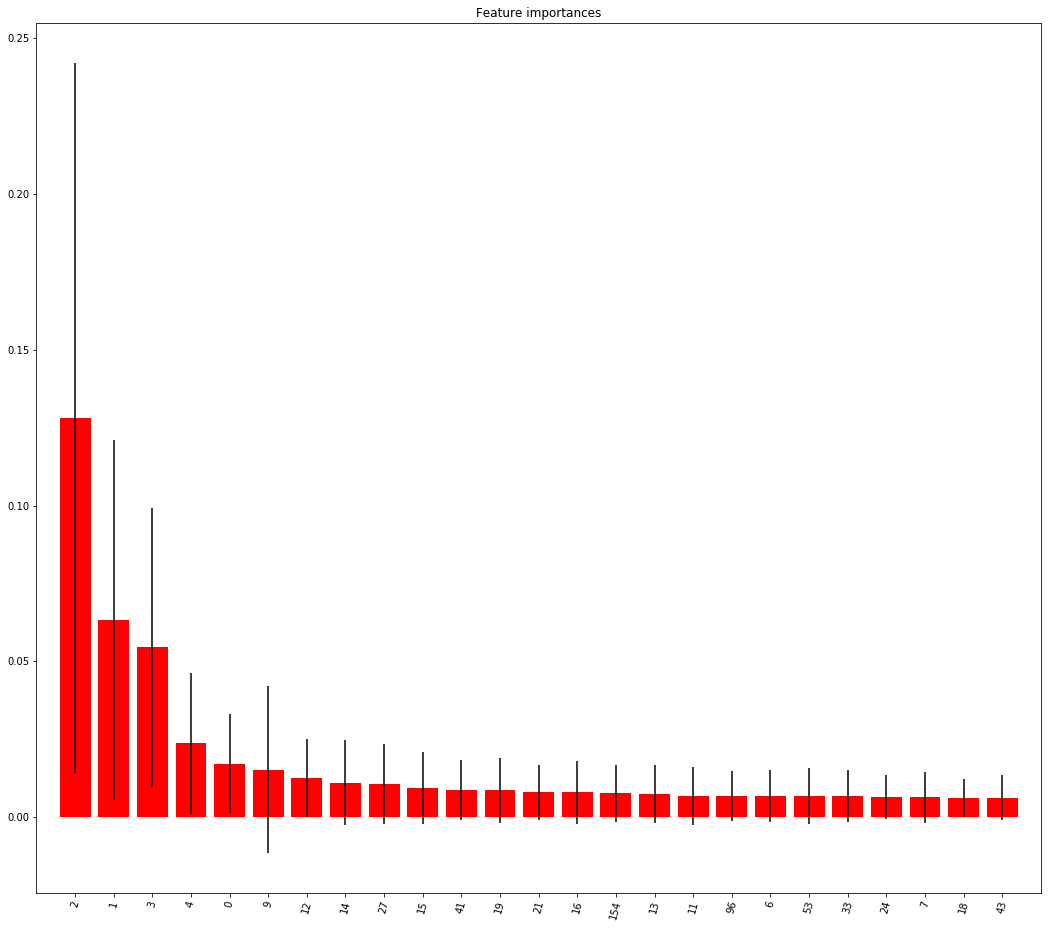

In [38]:
top_indices = indices[:25]
top_features = [i for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [39]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.003s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.9410
Accuracy of data not seen: 0.8917
F1 score: 0.8917
Recall score: 0.909091
False Negatives: 7


#### NearestCentroid

In [40]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.002s
NearestCentroid Scores:

Accuracy of data already seen: 0.9522
Accuracy of data not seen: 0.9236
F1 score: 0.9200
Recall score: 0.896104
False Negatives: 8


#### AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 0.944s
AdaBoostClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9363
F1 score: 0.9351
Recall score: 0.935065
False Negatives: 5


#### QuadraticDiscriminantAnalysis

In [42]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

done in 0.016s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 0.9856
Accuracy of data not seen: 0.9299
F1 score: 0.9241
Recall score: 0.870130
False Negatives: 10


#### GaussianProcessClassifier

In [43]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 0.198s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 0.9617
Accuracy of data not seen: 0.9363
F1 score: 0.9315
Recall score: 0.883117
False Negatives: 9


#### Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.078s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8854
F1 score: 0.8875
Recall score: 0.922078
False Negatives: 6


#### LogisticRegression

In [45]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.011s
LogisticRegression Scores:

Accuracy of data already seen: 0.9633
Accuracy of data not seen: 0.9363
F1 score: 0.9333
Recall score: 0.909091
False Negatives: 7


#### PassiveAggressiveClassifier

In [46]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.007s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.9633
Accuracy of data not seen: 0.9236
F1 score: 0.9241
Recall score: 0.948052
False Negatives: 4


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [47]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.012s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9681
Accuracy of data not seen: 0.9299
F1 score: 0.9272
Recall score: 0.909091
False Negatives: 7


#### SGDClassifier

In [48]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.004s
SGDClassifier Scores:

Accuracy of data already seen: 0.9075
Accuracy of data not seen: 0.8790
F1 score: 0.8848
Recall score: 0.948052
False Negatives: 4


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [49]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.040s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 0.9713
Accuracy of data not seen: 0.9363
F1 score: 0.9333
Recall score: 0.909091
False Negatives: 7


#### BaggingClassifier

In [50]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 1.550s
BaggingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8981
F1 score: 0.8974
Recall score: 0.909091
False Negatives: 7


#### VotingClassifier

In [51]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
#    ('nn',nn_clf),
#     ('nb',nb_clf),
#     ('et',et_clf),
    ('sgd',sgd_clf),
     ('svm',svm_clf),
#     ('lr',lr_clf),
#      ('nc',nc_clf),
#      ('knn',knn_clf),
#      ('cc',cc_clf),
    ('rd',rd_clf),
#      ('qda',qda_clf),
#     ('pa',pa_clf),
#     ('gb',gb_clf),
])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 0.027s


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [52]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
recall = recall_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('Recall score: %0.4f' % recall)
print('False Negatives: %0d' % FN)

VotingClassifier Scores:

Accuracy of data already seen: 0.9713
Accuracy of data not seen: 0.9299
F1 score: 0.9272
Recall score: 0.9091
False Negatives: 7


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [53]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest Recall Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['recall'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)    
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

AdaBoostClassifier: 0.9363
GaussianProcessClassifier: 0.9363
LogisticRegression: 0.9363


Best F1 Score:

AdaBoostClassifier: 0.9351
LogisticRegression: 0.9333
CalibratedClassifierCV: 0.9333


Best Recall Score:

PassiveAggressiveClassifier: 0.9481
SGDClassifier: 0.9481
AdaBoostClassifier: 0.9351


Best False Negative Classifier:

PassiveAggressiveClassifier: 4
SGDClassifier: 4
AdaBoostClassifier: 5


#### Confusion Matrix and ROC curves of Top Algos

In [54]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [56]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

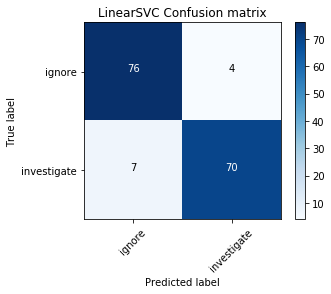

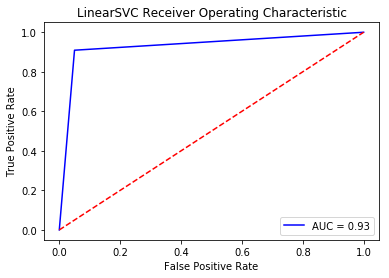

In [57]:
display_conf_mat(svm_clf,test_feats,test_labels)
plot_roc_curve(svm_clf,test_feats,test_labels)

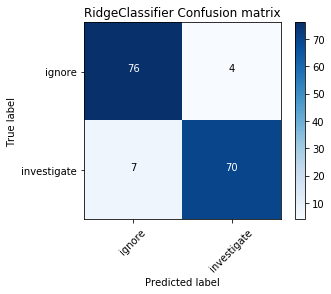

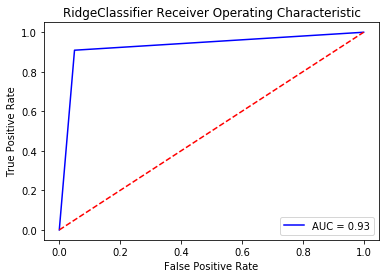

In [58]:
display_conf_mat(rd_clf,test_feats,test_labels)
plot_roc_curve(rd_clf,test_feats,test_labels)

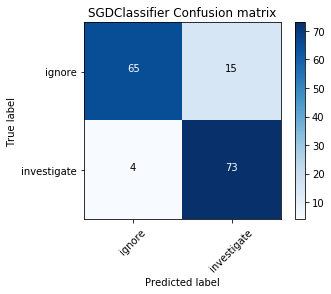

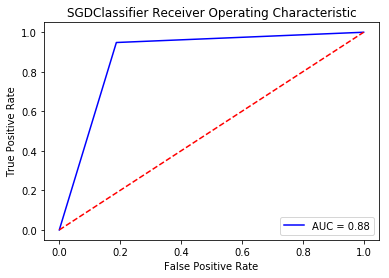

In [59]:
display_conf_mat(sgd_clf,test_feats,test_labels)
plot_roc_curve(sgd_clf,test_feats,test_labels)